In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import (AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier,
                              RandomForestClassifier)

from sklearn.metrics import (recall_score,
                             accuracy_score,
                             precision_score,
                             f1_score,
                             classification_report)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')



train_file = '../../Data/Raw/titanic/train.csv'
test_file = '../../Data/Raw/titanic/test.csv'
datapath = '../../Data/Processed/titanic_model.parquet'

# Carga dos Dados 

In [2]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
df = pd.read_parquet(datapath)

print('shape:', df.shape, train.shape, test.shape)
print('columns:', df.columns)

recursos = ['Sobreviveu', 'Sexo', 'Tarifa', 'TamanhoGrupo', 'SobrevivenciaGrupo',
       'Classe_2', 'Classe_3', 'PortoEmbarque_Q', 'PortoEmbarque_S',
       'Titulo_Casada', 'Titulo_Menino', 'Titulo_Solteira',
       'ExpectativaDeVida_Morrer', 'ExpectativaDeVida_Viver', 'Idade']

shape: (1309, 15) (891, 12) (418, 11)
columns: Index(['Sobreviveu', 'Sexo', 'Tarifa', 'TamanhoGrupo', 'SobrevivenciaGrupo',
       'Classe_2', 'Classe_3', 'PortoEmbarque_Q', 'PortoEmbarque_S',
       'Titulo_Casada', 'Titulo_Menino', 'Titulo_Solteira',
       'ExpectativaDeVida_Morrer', 'ExpectativaDeVida_Viver', 'Idade'],
      dtype='object')


## Transformando o IdPassageiro em Index

In [3]:
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [4]:
train = df.loc[train.index]
test =  df.loc[test.index]

test.drop('Sobreviveu', axis=1, inplace=True)

train.shape, test.shape

((891, 15), (418, 14))

## Definindo variáveis para treino

In [5]:
X = train.drop('Sobreviveu', axis=1)

y = train['Sobreviveu']

X.shape, y.shape

((891, 14), (891,))

# Treino / Teste 

In [6]:
# Dividir 30% dos dados para o conjunto out-of-sample de teste
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                y,
                                                                test_size=0.3,
                                                                random_state=123)

# Construção do Pipeline 

In [7]:
# Configure Pipeline
class ModeloAuxiliar(object):
    def __init__(self, clf, seed=0, params=None):
        if params:
            params['random_state'] = seed
            self.clf = clf(**params)
        else:
            self.clf = clf()
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def score(self,x,y):
        return self.clf.score(x,y)
    

modelos = [{'nome': 'logreg',
            'modelo': LogisticRegression},
           {'nome': 'etree',
            'modelo': ExtraTreesClassifier},
           {'nome': 'gradboost',
             'modelo': GradientBoostingClassifier}, 
           {'nome': 'adaboost',
             'modelo': AdaBoostClassifier},
           {'nome': 'SVC',
            'modelo': SVC},
           {'nome': 'KNN',
            'modelo': KNeighborsClassifier},
           {'nome': 'GaussianNB',
            'modelo': GaussianNB},
           {'nome': 'Perceptron',
            'modelo': Perceptron},
           {'nome': 'LinearSVC',
            'modelo': LinearSVC},
           {'nome': 'SGD',
            'modelo': SGDClassifier},
           {'nome': 'Dtree',
            'modelo': DecisionTreeClassifier},
           {'nome': 'RForest',
            'modelo': RandomForestClassifier}
          ]

resultados = []

for model in modelos:
    x = ModeloAuxiliar(clf=model['modelo'])
    
    # Treinando o modelo
    x.fit(X_train, y_train)
    
    # Gerando a predição
    x_pred = x.predict(X_test)
    
    # Verificando os Scores
    acuracia = round(x.score(X_test,y_test)*100,2)
    
    resultados.append({'Nome': model['nome'],
                       'Score': acuracia,
                       'Valor Previsto': x_pred })

# Ranking de Modelos Por Score

In [8]:
models = pd.DataFrame(resultados)

In [9]:
models[['Nome','Score']].sort_values(by='Score', ascending=False)

,Nome,Score
2,gradboost,92.54
8,LinearSVC,90.67
0,logreg,90.30
3,adaboost,89.55
11,RForest,88.43
6,GaussianNB,88.06
1,etree,86.57
10,Dtree,85.45
9,SGD,79.10
5,KNN,76.49


O modelo com melhor score foi o gradboost. Portanto continuar o processo utilizando esse modelo, vamos agora para a Validação Cruzada.

# Validação Cruzada

In [10]:
# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0)

ada = AdaBoostClassifier(n_estimators=200, random_state=0, learning_rate=0.1)
grd = GradientBoostingClassifier(n_estimators=200, random_state=0, learning_rate=0.1)
log = LogisticRegression()

resGRD = cross_val_score(grd, X_train, y_train, cv=cvfold, scoring='accuracy')
resADA = cross_val_score(ada, X_train, y_train, cv=cvfold, scoring='accuracy')
resLOG = cross_val_score(log, X_train, y_train, cv=cvfold, scoring='accuracy')

print('O score cross-validado do gradboost é:', resGRD.mean())
print('O score cross-validado do adadboost é:', resADA.mean())
print('O score cross-validado da regressão logistica é:', resLOG.mean())

O score cross-validado do gradboost é: 0.8700204813108039
O score cross-validado do adadboost é: 0.8908602150537634
O score cross-validado da regressão logistica é: 0.8988991295442906


In [11]:
grd.fit(X_train, y_train)
ada.fit(X_train, y_train)
log.fit(X_train, y_train)

grdPred = grd.predict(X_test)
adaPred = ada.predict(X_test)
logPred = log.predict(X_test)

# Matriz de Confusão 

Essa média as vezes pode ser enganosa. Nós podemos analisar a Matriz de Confusão _(Confusion Matrix)_ que nos mostra aonde o modelo errou. Falsos Positivos x Falso Negativos.

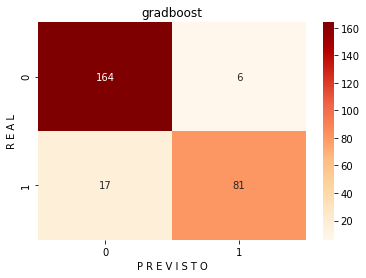

In [12]:
sns.heatmap(confusion_matrix(y_test,grdPred), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('gradboost')
plt.xlabel('P R E V I S T O')
plt.ylabel('R E A L')
plt.show()

Resumo da Matriz

* O número de Verdadeiros Positivo (VP) foi de 83. (Número de acertos do modelo para as pessoas que realmente viveram)
* O número de Vedadeiros Negativo (VN) foi de 164 ( Número de acertos do modelo para as pessoas que realmente morreram)
* O número de Falsos Positivo foi de 6. (Número de erros do modelo para as pessoas que morreram mas o modelo previu que viveram)
* O número de Falsos Negativo foi de 15. (Número de erros do modelo para as pessoas que viveram mas o modelo previu que morreram)

Agora vamos calcular as métricas do modelo. Primeiramente calcular a precisão.

### Precisão

O cálculo da precisão é (VP / ( VP + FP). Isto é, O número de acertos do modelo das pessoas que viveram, dividido pela soma dos acertos das pessoas que viveram com o que o modelo previu que viveram mas na verdade morreram.

In [13]:
precisao = precision_score(y_test,grdPred)
precisao

0.9310344827586207

Podemos ter certeza fazendo o cálculo manualmente. Sendo, VP = 83 e FP = 6, temos: 83 / (83+6)

In [14]:
83 / (83+6)

0.9325842696629213

### Recall

O cálculo da revocação é (VP / ( VP + FN). Isto é, o número de acertos do modelo das pessoas que viveram, dividido pela soma dos acertos das pessoas que viveram com o que o modelo previu que morreram mas na verdade viveram.

In [15]:
recall  = recall_score(y_test,grdPred)
recall

0.826530612244898

Double check, Sendo, VP = 83 e FP = 15, temos: 83 / (83+15)

In [16]:
83 / (83+15)

0.8469387755102041

### Acuracia

O cálculo da acurácia é (VP + VN / Total). Isto é, é o número de acertos das pessoas que viveram + o número de acerto das pessoas que morreram dividido pelo valor total da amostra. 

In [17]:
accuracy = accuracy_score(y_test,grdPred)
accuracy

0.914179104477612

Sendo, VP = 83 e VN = 164 temos: ((83+164)/ len(grdPred)) 

In [18]:
((83+164)/ len(grdPred)) 

0.9216417910447762

### F1-Score

O calculo do f1s-score é 2* ( (Precisão x Recall) / (Precisão + Recall)). Isto é, é uma valor mais balanceado sobre os dados positivos.

In [19]:
f1 = f1_score(y_test,grdPred)
f1

0.8756756756756757

Sendo, Precisão = 0.9325842696629213 e Recall = 0.8469387755102041, temos: 

In [20]:
2* ( (precisao * recall) / (precisao + recall))

0.8756756756756757

In [ ]:
sns.heatmap(confusion_matrix(y_test,adaPred), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('Adaboost')
plt.xlabel('P R E V I S T O')
plt.ylabel('R E A L')
plt.show()

In [ ]:
sns.heatmap(confusion_matrix(y_test,logPred), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('Logistic')
plt.xlabel('P R E V I S T O')
plt.ylabel('R E A L')
plt.show()

<a name="rocauc"></a>

# Curvas ROC e AUC 

O formato da curva contem várias informações, dentre elas, a taxa esperada de falsos positivos e taxa esperada de falsos negativos. 
* O quanto menor for o eixo x menor a quantidade de falsos positivos e maior verdadeiros negativos. 
* Quanto maiores os valores no eixo y, maior a quantidade de verdadeiros positivos e menor a quantidade de falsos negativos.

Vamos calcular as probabilidades de um modelo sem habilidade e os modelo do Gradboost e Adaboost

Sem habilidade: ROC AUC=0.500
gradboost: ROC AUC=0.932
adaboost: ROC AUC=0.940
logistic: ROC AUC=0.932


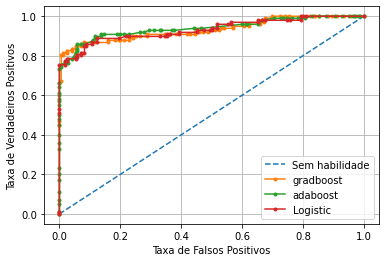

In [23]:
ns_probs = [0 for _ in range(len(y_test))] # no skill model

grd_probs = grd.predict_proba(X_test)[:,1]
ada_probs = ada.predict_proba(X_test)[:,1]
log_probs = log.predict_proba(X_test)[:,1]

ns_auc = roc_auc_score(y_test, ns_probs)
grd_auc = roc_auc_score(y_test, grd_probs)
ada_auc = roc_auc_score(y_test, ada_probs)
log_auc = roc_auc_score(y_test, log_probs)

print('Sem habilidade: ROC AUC=%.3f' %(ns_auc))
print('gradboost: ROC AUC=%.3f' %(grd_auc))
print('adaboost: ROC AUC=%.3f' %(ada_auc))
print('logistic: ROC AUC=%.3f' %(log_auc))

# calcular a curva ROC
ns_tfp, ns_tvp, _ = roc_curve(y_test, ns_probs)
grd_tfp, grd_tvp, _ = roc_curve(y_test, grd_probs)
ada_tfp, ada_tvp, _ = roc_curve(y_test, ada_probs)
log_tfp, log_tvp, _ = roc_curve(y_test, log_probs)

plt.plot(ns_tfp, ns_tvp, linestyle='--', label='Sem habilidade')
plt.plot(grd_tfp, grd_tvp, marker='.', label='gradboost')
plt.plot(ada_tfp, ada_tvp, marker='.', label='adaboost')
plt.plot(log_tfp, log_tvp, marker='.', label='Logistic')

plt.grid(True)
plt.legend()

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

plt.show()

# Customização de Hyper-Parâmetros 

**Parâmetros**

**n_jobs**: Quantidade de núcleos do CPU usados no processo de treino do modelo preditivo. Se for -1, todos os núcleos serão usados.

**n_estimators**: Quantidade de árvores de classificação usadas no modelo preditivo (10 é o padrão)

**max_depth**: Profundidade de árvore ou a quantidade de nós que ela deve se expandir. Se esse valor for muito alto, existe a chance de o modelo super-adequar _(overfit)_ o modelo.

**min_samples_leaf**: O número mínimo de amostras requeridas para ser considerado um ramo. Isso tende a suavizar o modelo.

**verbose**: Controla a saída de textos durante o processo de aprendizagem/treino. O valor 0 não mostra nenhum texto, enquanto 3 mostra o processo de aprendizagem de árvore a cada iteração.

* ### Random Forest

In [24]:
rf_params = {
    'n_estimators': [100,200],
    'max_depth': [2,4],
    'min_samples_leaf': [1,2,3]
}

gd = GridSearchCV(estimator=RandomForestClassifier(random_state=123),
                 param_grid=rf_params, verbose=True);

gd.fit(X_train,y_train);

print(gd.best_score_);
print(gd.best_estimator_);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8941032258064517
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    9.8s finished


In [25]:
gd_pred = gd.predict(X_test)
gd_pred

array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.

<a name="ensembling"></a>

# Ensembling
Uma forma de aumentar a acuracidade ou performance do modelo preditivo. Ensembling é a combinação de vários modelos preditivos de forma a ter uma versão final mais poderosa e mais estável. Ensembling pode ser feito de 3 formas:
* Classificão de Votos (Voting Classifier)
* Ensacamento (Bagging)
* Impulsionamento (Boosting)

<a name="voting"></a>

* ### Classificação de Votos

In [26]:
misturados = [('KNN',KNeighborsClassifier(n_neighbors=10)),
                  ('RBF',SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                  ('RFor',RandomForestClassifier(n_estimators=100,random_state=123)),
                  ('LR',LogisticRegression(C=0.05)),
                  ('DT',DecisionTreeClassifier(random_state=123)),
                  ('NB',GaussianNB()),
                  ('svm',SVC(kernel='linear',probability=True))
                 ]

In [27]:
from sklearn.ensemble import VotingClassifier

meu_ensemble = VotingClassifier(estimators=misturados, voting='soft').fit(X_train,y_train)

print('Score', meu_ensemble.score(X_test, y_test))
cross = cross_val_score(meu_ensemble,X_test, y_test, cv=10, scoring='accuracy') 
print('Score cross-validado', cross.mean())

Score 0.8955223880597015
Score cross-validado 0.8955840455840456


<a name="bagging"></a>

# Importância de Recursos _(Feature Importance)_ 


In [28]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_depth': 2,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [29]:
rf = ModeloAuxiliar(clf=RandomForestClassifier, seed=123, params=rf_params)

In [30]:
rf_features = rf.feature_importances(X_train,y_train)

In [31]:
rf_features

array([1.73369808e-01, 5.67973107e-02, 1.84255235e-01, 3.22672621e-01,
       2.01548783e-03, 3.74079697e-02, 2.59268332e-04, 8.73586013e-03,
       1.81578500e-02, 6.15950696e-03, 4.62858794e-02, 2.96605697e-02,
       1.08296339e-01, 5.92629438e-03])

In [32]:
cols = X_train.columns.values
cols

array(['Sexo', 'Tarifa', 'TamanhoGrupo', 'SobrevivenciaGrupo', 'Classe_2',
       'Classe_3', 'PortoEmbarque_Q', 'PortoEmbarque_S', 'Titulo_Casada',
       'Titulo_Menino', 'Titulo_Solteira', 'ExpectativaDeVida_Morrer',
       'ExpectativaDeVida_Viver', 'Idade'], dtype=object)

In [33]:
feature_dataframe = pd.DataFrame({'recursos': cols, 
                                  'Importância de Recursos RForest': rf_features})

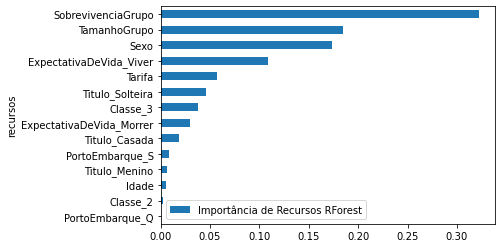

In [34]:
feature_dataframe.sort_values(by='Importância de Recursos RForest').plot.barh(x='recursos')

In [ ]:
meu_ensemble.fit(X_train,y_train)

In [ ]:
meu_ensemble.score(X_test, y_test)

In [ ]:
test.shape

In [ ]:
X_test.shape

In [ ]:
ensemble_pred = meu_ensemble.predict(test)

In [ ]:
ensemble_pred.shape

In [ ]:
test.index

<a name="submissao"></a>

# Submissão

In [ ]:
submissao = pd.DataFrame({
    'PassengerId': test.index,
    'Survived': ensemble_pred
})


In [ ]:
submissao.to_excel('../../Data/Modeling/results.xlsx', index= False)

submissao.head()